In [1]:
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from collections import defaultdict

Сгенерируем вероятности выиграть для ручек как случайную величину из степенного распределения так, чтобы большинство ручек имели малую вероятность выиграть и лишь несколько

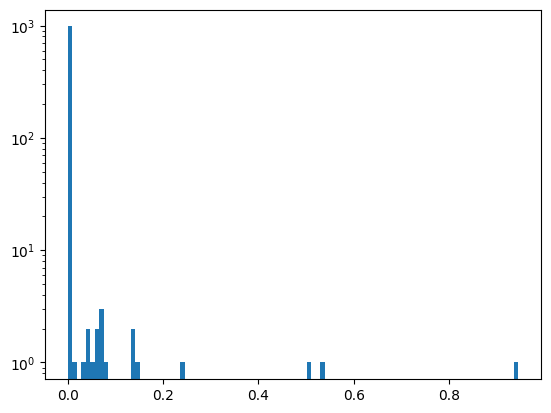

In [2]:
n_arms = 1_000
np.random.seed(42)

p = np.random.power(5e-3, n_arms)

plt.hist(p, bins=100)
# отобразим в логарифмической шкале, чтобы увидеть несколько значений вне 0
plt.yscale('log')
plt.show();

Далее мы проведем эксперимент с различными алгоритмами для оценки метрики **regret** – как много награды мы упустили по сравнению с ситуацией, если бы выбирали только самую оптимальную ручку

## $\epsilon$-greedy

Суть проста: каждый раз мы с вероятностью $\epsilon$ выбераем случайную ручку (exploitation), иначе выбераем такую, у которой максимальна средняя награда (exploration)

Недостаток такого метода в том, что баланса exploration-exploitation никак не меняется со временем, что мы исправим в следующем методе

In [3]:
class BaseBandit:
    def sample(self) -> int:
        raise NotImplementedError()

    def retrieve_reward(self, ind: int, reward: float):
        raise NotImplementedError()

        
class EpsilonGreedyBandit(BaseBandit):
    def __init__(self, n_arms: int, eps: float = 0.05):
        super().__init__()
        self.eps = eps
        self.n_arms = n_arms
        self.arms_stat = {}
        
    def sample(self) -> int:
        if np.random.rand() < self.eps or not self.arms_stat:
            # c вероятностью epsilon (или если нет статистики для ручек) выбираем случайную
            return np.random.choice(self.n_arms)
        else:
            # иначе сортируем ручки по убыванию средней награды и выбираем максимальную
            return sorted(self.arms_stat.items(), key=lambda x: -x[1][1] / x[1][0])[0][0]
    
    def retrieve_reward(self, ind: int, reward: float):
        n_trials, reward_sum = self.arms_stat.get(ind, [0, 0])
        # обновляем число попыток и суммарную награду в статистике ручек
        self.arms_stat[ind] = (n_trials + 1, reward_sum + reward)

In [4]:
def evaluate_algo(algo: BaseBandit):
    np.random.seed(42)
    reward_rng = np.random.default_rng(42)

    reward_list = []
    for _ in range(n_iterations):
        # выбираем оптимальную ручку алгоритмом
        arm_ind = algo.sample()
        # награда равна 1 с вероятностью выигрыша для выбранной ручки
        reward = reward_rng.choice(2, p=[1 - p[arm_ind], p[arm_ind]])

        # сообщаем алгоритму награду для выбранной ручки
        algo.retrieve_reward(arm_ind, reward)
        reward_list.append(reward)
    
    return reward_list

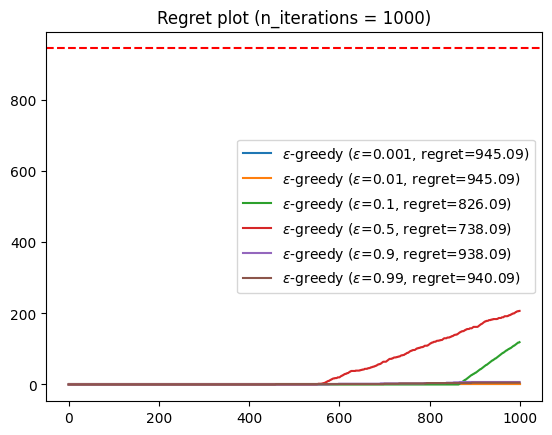

In [5]:
n_iterations = 1000
max_reward = max(p) * n_iterations

# переберем различные параметры eps для алгоритма
for eps in [0.001, 0.01, 0.1, 0.5, 0.9, 0.99]:
    np.random.seed(42)
    algo = EpsilonGreedyBandit(n_arms, eps)
    reward_list = evaluate_algo(algo)

    plt.plot(np.cumsum(reward_list), label=f'$\epsilon$-greedy ($\epsilon$={eps}, regret={max_reward - sum(reward_list):.2f})')
    
plt.axhline(y=max_reward, c='r', linestyle='--')
plt.legend()
plt.title(f'Regret plot (n_iterations = {n_iterations})')
plt.show();

Проделаем тот же эксперимент 100_000 раз

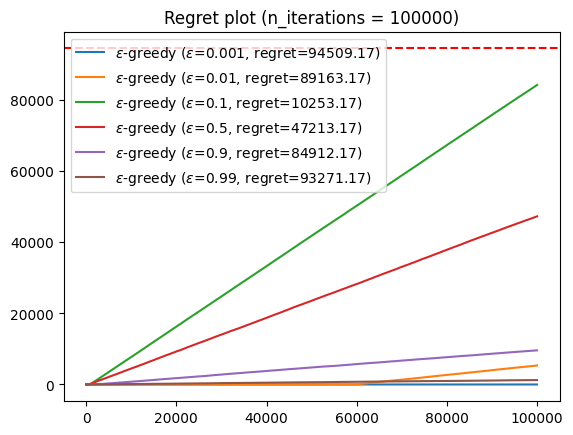

In [6]:
n_iterations = 100_000
max_reward = max(p) * n_iterations

for eps in [0.001, 0.01, 0.1, 0.5, 0.9, 0.99]:
    np.random.seed(42)
    algo = EpsilonGreedyBandit(n_arms, eps)
    reward_list = evaluate_algo(algo)

    plt.plot(np.cumsum(reward_list), label=f'$\epsilon$-greedy ($\epsilon$={eps}, regret={max_reward - sum(reward_list):.2f})')
    
plt.axhline(y=max_reward, c='r', linestyle='--')
plt.legend()
plt.title(f'Regret plot (n_iterations = {n_iterations})')
plt.show();

Самим оптимальным параметром для горизонта событий 1_000 итераций оказался $\epsilon = 0.5$ (**regret = 738**)

Для горизонта событий 100_000 лучше себя показал алгоритм $\epsilon = 0.1$ (**regret = 10253**)

## Затухающий $\epsilon$-greedy

Все то же самое, что и раньше, только теперь $\epsilon$ параметр уменьшается с течением времени, то есть с течением времени мы перестаем исследовать и уже пользуемся только максимально надежной ручкой

In [19]:
class DecayingEpsilonGreedyBandit(BaseBandit):
    def __init__(self, n_arms: int, initial_eps: float = 0.05, n_iterations: int = None, final_eps: float = 0.):
        super().__init__()
        
        self.initial_eps = initial_eps
        self.final_eps = final_eps
        self.n_iterations = n_iterations
        self.cur_iteration = 0
        
        self.n_arms = n_arms
        self.arms_stat = {}
        
    def get_eps(self):
        if self.n_iterations is None:
            return self.initial_eps
        else:
            # в процессе работы будем линейно уменьшать параметр eps с изначального значения до 0
            progress = (self.n_iterations - self.cur_iteration) / self.n_iterations
            return progress * self.initial_eps + (1 - progress) * self.final_eps
        
    def sample(self) -> int:
        if np.random.rand() < self.get_eps() or not self.arms_stat:
            return np.random.choice(self.n_arms)
        else:
            return sorted(self.arms_stat.items(), key=lambda x: -x[1][1] / x[1][0])[0][0]
    
    def retrieve_reward(self, ind: int, reward: float):
        self.cur_iteration += 1
        n_trials, reward_sum = self.arms_stat.get(ind, [0, 0])
        self.arms_stat[ind] = (n_trials + 1, reward_sum + reward)

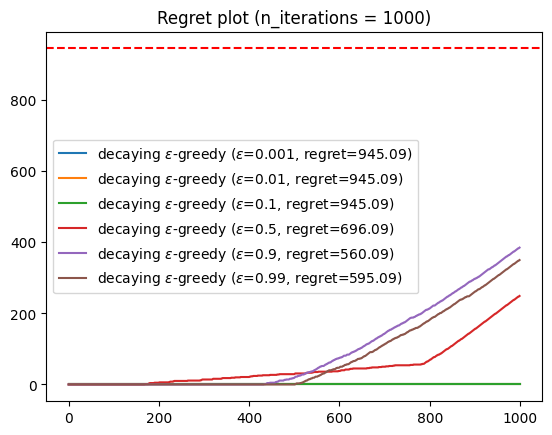

In [22]:
n_iterations = 1000
max_reward = max(p) * n_iterations

for eps in [0.001, 0.01, 0.1, 0.5, 0.9, 0.99]:
    np.random.seed(42)
    algo = DecayingEpsilonGreedyBandit(n_arms, eps, n_iterations)
    reward_list = evaluate_algo(algo)

    plt.plot(np.cumsum(reward_list), label=f'decaying $\epsilon$-greedy ($\epsilon$={eps}, regret={max_reward - sum(reward_list):.2f})')
    
plt.axhline(y=max_reward, c='r', linestyle='--')
plt.legend()
plt.title(f'Regret plot (n_iterations = {n_iterations})')
plt.show();

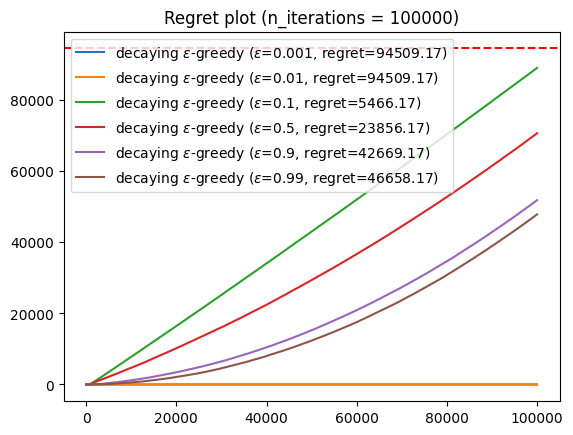

In [23]:
n_iterations = 100_000
max_reward = max(p) * n_iterations

for eps in [0.001, 0.01, 0.1, 0.5, 0.9, 0.99]:
    np.random.seed(42)
    algo = DecayingEpsilonGreedyBandit(n_arms, eps, n_iterations)
    reward_list = evaluate_algo(algo)

    plt.plot(np.cumsum(reward_list), label=f'decaying $\epsilon$-greedy ($\epsilon$={eps}, regret={max_reward - sum(reward_list):.2f})')
    
plt.axhline(y=max_reward, c='r', linestyle='--')
plt.legend()
plt.title(f'Regret plot (n_iterations = {n_iterations})')
plt.show();

Простым добавлением затухания параметра $\epsilon$ получили хорошее улучшение метрики в обоих случаях. Вместо линейного затухания можно выбрать другие стратегии (например, экспоненциальное или добавить синусоиду, чтобы со временем снова исследовать больше состояний)

Самим оптимальным параметром для горизонта событий 1_000 итераций оказался $\epsilon = 0.9$ (**regret = 560**)

Для горизонта событий 100_000 лучше себя показал алгоритм $\epsilon = 0.1$ (**regret = 5466**)

## UCB-1

Алгоритм сначала пробует дернуть за каждую ручку (exploration), после чего использует следующую формулу (exploitation + exploration): $\mu_j + \sqrt{\frac{2 \ln{n}}{n_j}}$, где $\mu_j$ – средняя награда для j-ой ручки, $n_j$ – сколько раз выбирали j-ую ручку и $n$ – общее число попыток

In [10]:
class UCBBandit(BaseBandit):
    def __init__(self, n_arms: int, alpha: float = 1.0):
        super().__init__()
        
        self.cur_iteration = 0
        
        self.n_arms = n_arms
        self.mu = np.zeros(n_arms)
        self.n_j = np.zeros(n_arms)
        
        self.alpha = alpha
        
    def sample(self) -> int:
        if self.cur_iteration < self.n_arms:
            return self.cur_iteration
        
        return np.argmax(self.mu + self.alpha * np.sqrt(2 * np.log(self.cur_iteration) / self.n_j))
    
    def retrieve_reward(self, ind: int, reward: float):
        self.cur_iteration += 1
        self.mu[ind] = (self.mu[ind] * self.n_j[ind] + reward) / (self.n_j[ind] + 1)
        self.n_j[ind] += 1

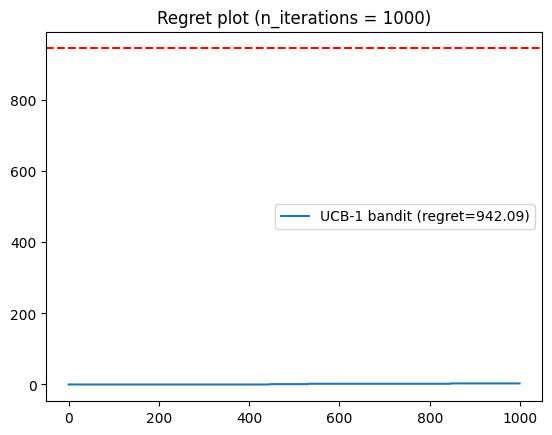

In [11]:
n_iterations = 1_000
max_reward = max(p) * n_iterations

np.random.seed(42)
algo = UCBBandit(n_arms)
reward_list = evaluate_algo(algo)

plt.plot(np.cumsum(reward_list), label=f'UCB-1 bandit (regret={max_reward - sum(reward_list):.2f})')
    
plt.axhline(y=max_reward, c='r', linestyle='--')
plt.legend()
plt.title(f'Regret plot (n_iterations = {n_iterations})')
plt.show();

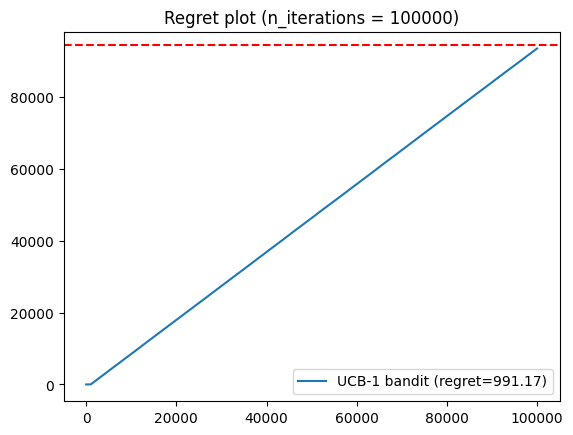

In [13]:
n_iterations = 100_000
max_reward = max(p) * n_iterations

np.random.seed(42)
algo = UCBBandit(n_arms, alpha=0.01)  # уменьшим коэффициент exploration для получения лучших результатов
reward_list = evaluate_algo(algo)

plt.plot(np.cumsum(reward_list), label=f'UCB-1 bandit (regret={max_reward - sum(reward_list):.2f})')
    
plt.axhline(y=max_reward, c='r', linestyle='--')
plt.legend()
plt.title(f'Regret plot (n_iterations = {n_iterations})')
plt.show();

Для горизонта 1_000 такой алгоритм не подходит, так как он при инициализации должен проверить кажду ручку, что является проблемой при большом количестве возможных действий

При этом для горизонта 100_000 такой алгоритм показал себя куда лучше предыдущих алгоритмов (**regret = 991**)

## Thomspon sampling

Для метода используется $B(\alpha, \beta)$ распределение, где $\alpha$ – количество положительных исходов, $\beta$ – количество негативных исходов

![image.png](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Beta_distribution_pdf.svg/650px-Beta_distribution_pdf.svg.png)

In [14]:
class ThompsonSamplingBandit(BaseBandit):
    def __init__(
        self,
        n_arms: int,
        init_alpha: float = 1.,
        init_beta: float = 1.,
        alpha_weight: float = 1.,
        beta_weight: float = 1.,
    ):
        super().__init__()
        
        self.cur_iteration = 0
        
        self.n_arms = n_arms
        self.alpha = np.zeros(n_arms) + init_alpha
        self.beta = np.zeros(n_arms) + init_beta
        
        self.alpha_weight = alpha_weight
        self.beta_weight = beta_weight
        
    def sample(self) -> int:
        return np.argmax(np.random.beta(self.alpha_weight * self.alpha, self.beta_weight * self.beta))
    
    def retrieve_reward(self, arm_ind: int, reward: float):
        if reward > 0:
            self.alpha[arm_ind] += 1
        else:
            self.beta[arm_ind] += 1

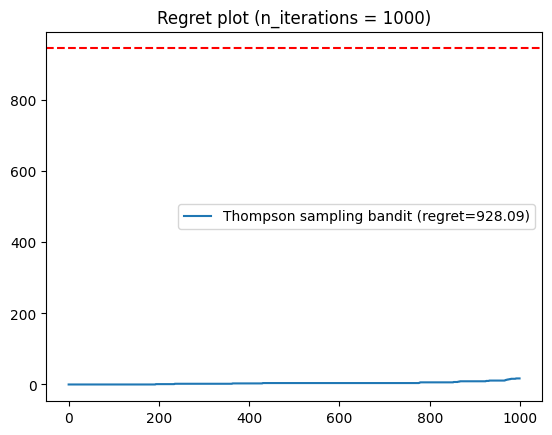

In [15]:
n_iterations = 1_000
max_reward = max(p) * n_iterations

np.random.seed(42)
algo = ThompsonSamplingBandit(n_arms)
reward_list = evaluate_algo(algo)

plt.plot(np.cumsum(reward_list), label=f'Thompson sampling bandit (regret={max_reward - sum(reward_list):.2f})')
    
plt.axhline(y=max_reward, c='r', linestyle='--')
plt.legend()
plt.title(f'Regret plot (n_iterations = {n_iterations})')
plt.show();

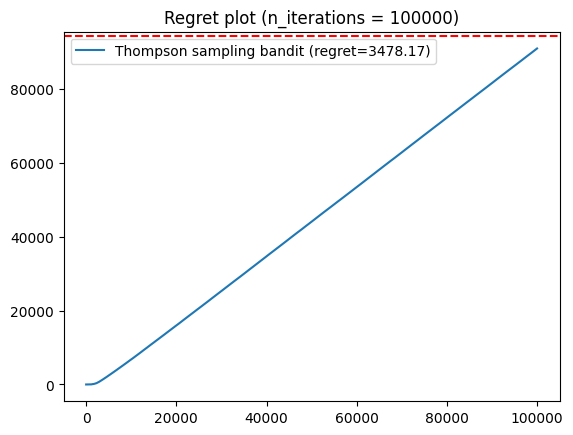

In [18]:
n_iterations = 100_000
max_reward = max(p) * n_iterations

np.random.seed(42)
algo = ThompsonSamplingBandit(n_arms, alpha_weight=1., beta_weight=1.)
reward_list = evaluate_algo(algo)

plt.plot(np.cumsum(reward_list), label=f'Thompson sampling bandit (regret={max_reward - sum(reward_list):.2f})')
    
plt.axhline(y=max_reward, c='r', linestyle='--')
plt.legend()
plt.title(f'Regret plot (n_iterations = {n_iterations})')
plt.show();

На горизонте 1_000 такой алгоритм показал себя лучше (**regret = 928**), так как не использует детерменированную стратегию и не обязан проверять каждую ручку. Однако алгоритм на коротком горизонте событий работает все равно хуже, чем $\epsilon$-greedy, так как должен собрать больше информации о среде

На горизонте событий 100_000 он сработал чуть хуже (**regret = 3478**), чем UCB-1. Однако, поменяв параметры `alpha_weight` и `beta_weight` для большего веса событиям, можно получить самую лучшую метрику regret